# Stochastic volatility: quasi-maximum likelihood

This notebook describes estimating the basic univariate stochastic volatility model by quasi-maximum likelihood methods, as in Ruiz (1994) or Harvey et al. (1994), using the Python package statsmodels.

The code defining the model is also available in a Python script [`sv.py`](https://github.com/ChadFulton/tsa-notebooks/blob/master/src/sv.py).

In [1]:
%matplotlib inline
from __future__ import division

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

A canonical univariate stochastic volatility model (Kim et al., 1998) is:

$$
\begin{align}
y_t & = e^{h_t / 2} \varepsilon_t & \varepsilon_t \sim N(0, 1)\\
h_{t+1} & = \mu + \phi(h_t - \mu) + \sigma_\eta \eta_t \qquad & \eta_t \sim N(0, 1) \\
h_1 & \sim N(\mu, \sigma_\eta^2 / (1 - \phi^2))
\end{align}
$$

We can transform the model for $y_t$ into a linear model in $\log y_t^2$, we have:

$$
\begin{align}
\log y_t^2 & = h_t + \log \varepsilon_t^2\\
h_{t+1} & = \mu + \phi(h_t - \mu) + \sigma_\eta \eta_t \\
h_1 & \sim N(\mu, \sigma_\eta^2 / (1 - \phi^2))
\end{align}
$$

here, $E(\log \varepsilon_t^2) \approx -1.27$ and $Var(\log \varepsilon_t^2) = \pi^2 / 2$.

## Quasi-likelihood - state space model

The quasi-likelihood approach (see e.g. Ruiz [1994] or Harvey et al. [1994]) replaces $\log \varepsilon_t^2$ with $E(\log \varepsilon_t^2) + \xi_t$ where $\xi_t \sim N(0, \pi^2 / 2)$. With this replacement, the model above becomes a linear Gaussian state space model and the Kalman filter can be used to compute the log-likelihoods using the prediction error decomposition.

Since $\log \varepsilon_t^2 - E(\log \varepsilon_t^2) \not \sim N(0, \pi^2 / 2)$, this is a quasi-maximum likelihood estimation routine that will only be valid asymptotically. However, Ruiz (1994) suggests that it may perform well nonetheless.

## Example: daily exchange rates

As an example, we replicate the results of Harvey et al (1994), in which daily exchange rates between October 1, 1981 and June 28, 1985 are examined via the stochastic volatility model above.

### Data

Harvey et al. (1994) consider the following exchange rates:

- Pound / Dollar (USXUK)
- Deutschmark / Dollar (USXGER)
- Yen / Dollar (USXJPN)
- Swiss-Franc / Dollar (USXUI)

Tom Doan of the RATS econometrics software package has made available the replication data at https://estima.com/forum/viewtopic.php?f=8&t=1595.

*** No CODEPAGE record, no encoding_override: will use 'ascii'


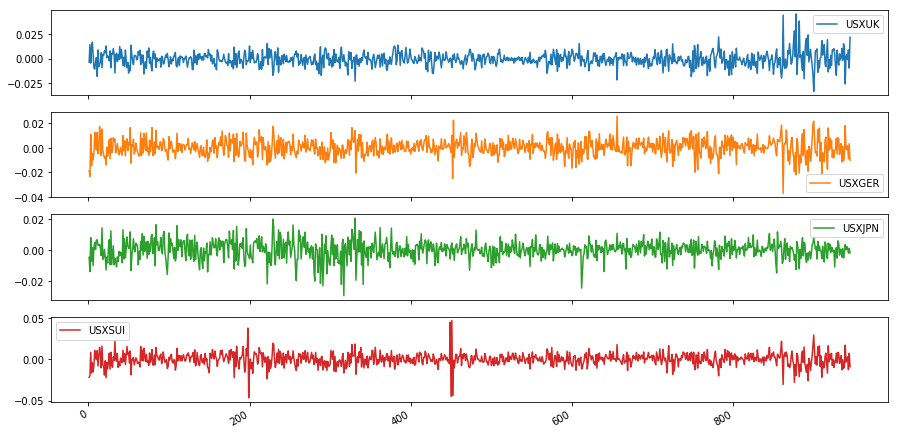

In [9]:
ex = pd.read_excel('data/xrates.xls')
dta = np.log(ex).diff().iloc[1:]
dta.plot(subplots=True, figsize=(15, 8));

### Model

We can relatively easily construct the state space model in Statsmodels. This code is also given in the associated file [`sv.py`](../files/sv.py).

In [3]:
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)

# "Quasi-likelihood stochastic volatility"
class QLSV(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Convert to log squares
        endog = np.log(endog**2)

        # Initialize the base model
        super(QLSV, self).__init__(endog, k_states=1, k_posdef=1,
                                   initialization='stationary')
        
        # Setup the observation covariance
        self['obs_intercept', 0, 0] = -1.27
        self['design', 0, 0] = 1
        self['obs_cov', 0, 0] = np.pi**2 / 2
        self['selection', 0, 0] = 1.
        
    @property
    def param_names(self):
        return ['phi', 'sigma2_eta', 'mu']
    
    @property
    def start_params(self):
        return np.r_[0.9, 1., 0.]
    
    def transform_params(self, params):
        return np.r_[constrain_stationary_univariate(params[:1]), params[1]**2, params[2:]]
    
    def untransform_params(self, params):
        return np.r_[unconstrain_stationary_univariate(params[:1]), params[1]**0.5, params[2:]]

    def update(self, params, **kwargs):
        super(QLSV, self).update(params, **kwargs)
        
        gamma = params[2] * (1 - params[0])
        self['state_intercept', 0, 0] = gamma
        self['transition', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]


### Notes

There are two important notes that will be needed to compare our results to those of Harvey et al. (1994):

1. Recall that Harvey et al. (1994) estimate the intercept $\gamma$ rather than the mean $\mu$, so to compare our estimated mean to their estimated intercept, convert with $\gamma = \mu * (1 - \phi)$.
2. Harvey et al. (1994) do not include the constant part of the loglikelihood $(-0.5 T \log(2 \pi))$ in their reported results, so to compare our likelihood value to theirs we must substract that constant.

### Pound / Dollar

In [4]:
# Harvey et al. demean the data before estimating to avoid problems
# with taking logs of zeros.
endog = dta['USXUK'] - dta['USXUK'].mean()

# Fit the model
mod_usxuk = QLSV(endog)
res_usxuk = mod_usxuk.fit(cov_type='robust')

# Print the intercept that is comparable to Harvey et al (1994)
print('Gamma = %.4f' % (res_usxuk.params[2] * (1 - res_usxuk.params[0])))
# Print the loglikelihood that is comparable to Harvey et al (1994)
print('log L = %.2f' % (res_usxuk.llf - (-np.log(2 * np.pi) * mod_usxuk.nobs / 2)))

# Print the estimation summary
print(res_usxuk.summary())

Gamma = -0.0878
log L = -1212.82
                           Statespace Model Results                           
Dep. Variable:                  USXUK   No. Observations:                  945
Model:                           QLSV   Log Likelihood               -2081.220
Date:                Sat, 14 Apr 2018   AIC                           4168.439
Time:                        21:57:57   BIC                           4182.993
Sample:                             0   HQIC                          4173.986
                                - 945                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.9912      0.007    134.755      0.000       0.977       1.006
sigma2_eta     0.0070      0.005      1.356      0.175      -0.003       0.017
mu           -10.00

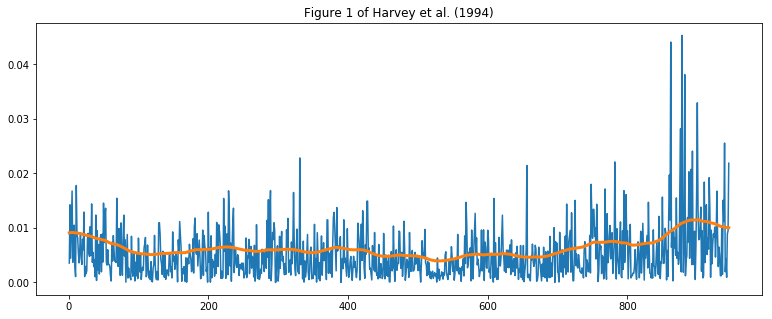

In [5]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(np.abs(dta['USXUK']))
ax.plot(dta.index, np.exp(res_usxuk.smoothed_state[0] / 2), linewidth=3)
ax.set(title='Figure 1 of Harvey et al. (1994)');

### Fit remaining models

We repeat the above exercise for the Deutschmark, Yen, and Swiss-Franc.

In [6]:
# Deutschmark / Dollar
mod_usxger = QLSV(dta['USXGER'] - dta['USXGER'].mean())
res_usxger = mod_usxger.fit(cov_type='robust')
print('Deutschmark / Dollar')
print('  phi        = %.4f' % res_usxger.params[0])
print('  sigma2_eta = %.4f' % res_usxger.params[1])
print('  gamma      = %.4f' % (res_usxger.params[2] * (1 - res_usxger.params[0])))
print('  log L      = %.2f' % (res_usxger.llf - (-np.log(2 * np.pi) * mod_usxger.nobs / 2)))

Deutschmark / Dollar
  phi        = 0.9649
  sigma2_eta = 0.0313
  gamma      = -0.3529
  log L      = -1232.26


In [7]:
# Yen / Dollar
mod_usxjpn = QLSV(dta['USXJPN'] - dta['USXJPN'].mean())
res_usxjpn = mod_usxjpn.fit()
print('Yen / Dollar')
print('  phi        = %.4f' % res_usxjpn.params[0])
print('  sigma2_eta = %.4f' % res_usxjpn.params[1])
print('  gamma      = %.4f' % (res_usxjpn.params[2] * (1 - res_usxjpn.params[0])))
print('  log L      = %.2f' % (res_usxjpn.llf - (-np.log(2 * np.pi) * mod_usxjpn.nobs / 2)))

Yen / Dollar
  phi        = 0.9947
  sigma2_eta = 0.0049
  gamma      = -0.0556
  log L      = -1272.64


In [8]:
# Swiss-Franc / Dollar
mod_usxsui = QLSV(dta['USXSUI'] - dta['USXSUI'].mean())
res_usxsui = mod_usxsui.fit()
print('Swiss-Franc / Dollar')
print('  phi        = %.4f' % res_usxsui.params[0])
print('  sigma2_eta = %.4f' % res_usxsui.params[1])
print('  gamma      = %.4f' % (res_usxsui.params[2] * (1 - res_usxsui.params[0])))
print('  log L      = %.2f' % (res_usxsui.llf - (-np.log(2 * np.pi) * mod_usxjpn.nobs / 2)))

Swiss-Franc / Dollar
  phi        = 0.9581
  sigma2_eta = 0.0459
  gamma      = -0.4180
  log L      = -1288.51
